# Infant Mortality in Asian Countries: A Data-Driven Exploration

# Introduction

Infant mortality, the death of infants within the first year of life, is a critical indicator of a population's health and well-being. Understanding the factors that contribute to infant mortality rates is crucial for policymakers, healthcare professionals, and researchers seeking to improve the health outcomes of vulnerable populations.

This project focuses on examining infant mortality in Asian countries, a region known for its diverse population, cultural richness, and varying levels of socioeconomic development. By investigating the factors associated with infant mortality in Asia, we aim to gain insights into the unique challenges and opportunities for improving infant health in this region.

The study utilizes a combination of cross-sectional and time series data to capture both the static and dynamic aspects of infant mortality. The dataset includes information on various factors such as adolescent birth rates, access to healthcare services, sanitation facilities, and socioeconomic indicators. By analyzing these variables, we can identify key drivers and patterns that contribute to variations in infant mortality rates across different countries in Asia.

In this project, we employ advanced data analysis techniques, including exploratory data analysis, regression modeling, time series analysis, and machine learning, to uncover important insights and develop predictive models. The ultimate goal is to provide evidence-based recommendations and interventions that can effectively reduce infant mortality rates and improve the health outcomes of infants and their families in Asian countries.

Through this project, we aim to contribute to the broader field of public health and inform policymakers, healthcare practitioners, and other stakeholders about effective strategies to address the complex issue of infant mortality in Asia. By understanding the underlying factors and trends, we can work towards creating targeted interventions and policies that have the potential to save countless infant lives and ensure a healthier future for the region.

# Data

- Mortality rate, infant (per 1,000 live births)

- Physicians (per 1,000 people)

- Nurses and midwives (per 1,000 people)

- Births attended by skilled health staff (% of total)

- Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)

- Adolescent fertility rate (births per 1,000 women ages 15-19)

- Current health expenditure (% of GDP)

- Mortality rate, infant (per 1,000 live births)

- People using at least basic sanitation services (% of population): 
    Basic sanitation is defined as having access to facilities for the safe disposal of human waste (feces and urine), as well as having the ability to maintain hygienic conditions, through services such as garbage collection, industrial/hazardous waste management, and wastewater treatment and disposal.

- People using safely managed drinking water services (% of population): 
    Basic drinking water services is defined as drinking water from an improved source, provided collection time is not more than 30 minutes for a round trip.

- People with basic handwashing facilities including soap and water (% of population): 
    The percentage of population living in households that have a handwashing facility with soap and water at home. Handwashing facilities can consist of a sink with tap water, but can also include other devices that contain, transport or regulate the flow of water. Buckets with taps, tippy-taps and portable basins are all examples of handwashing facilities. Bar soap, liquid soap, powder detergent and soapy water all count as soap for monitoring purposes.

- People using safely managed sanitation services (% of population)
    Population using an improved sanitation facility that is not shared with other households and where excreta are safely disposed of in situ or treated off site. Improved sanitation facilities include flush/pour flush to piped sewer systems, septic tanks or pit latrines; pit latrines with slabs (including ventilated pit latrines), and composting toilets.

In [4]:
import os
import pandas as pd

directory = "G:/Documents/Projects/InfantMortality/data"

csv_files = os.listdir(directory)

# Read each CSV file and assign it to a variable with the same name as the file
for file in csv_files:
    file_path = os.path.join(directory, file)
    df_name = os.path.splitext(file)[0]  # Extract the file name without extension
    
    # Read CSV file and assign to a variable with the same name as the file
    globals()[df_name] = pd.read_csv(file_path)

In [5]:
# Getting the names of all dataframes
df_names = [df_name.replace('.csv','') for df_name in csv_files]

In [6]:
# A function to unpivot a dataframe
def unpivot(dfname):
    df = globals()[dfname]
    
    df.drop(['Indicator Code'], axis = 1, inplace=True)
    
    df_reshaped = pd.melt(
    df,
    id_vars=['Country Name', 'Indicator Name', 'Country Code'],
    value_vars=df.loc[:,~df.columns.isin(['Country Name', 'Indicator Name', 'Country Code'])],
    var_name='Year',
    value_name=dfname
    )
    
    # Removing the constant Indicator column
    df_reshaped.drop('Indicator Name', axis = 1, inplace = True)
    
    #Rename the columns
    df_reshaped.rename(columns={'Country Name': 'Country'}, inplace=True)

    # Sort the DataFrame by Country and Year
    df_reshaped.sort_values(['Country', 'Year'], inplace=True)

    # Reset the index
    df_reshaped.reset_index(drop=True, inplace=True)
    
    return df_reshaped

In [7]:
for dfname in df_names:
    globals()[dfname] = unpivot(dfname)

In [8]:
# Check whether year is a int64 in all dataframes; if not, change it
for dfname in df_names:
    df = globals()[dfname]
    if df.Year.dtype != 'int64':
        globals()[dfname].Year = df.Year.astype('int64')

In [9]:
# Calculating global infant mortality rate
global_avg_mortality = infantMortalityRate.infantMortalityRate.mean()

In [10]:
df_names2 = df_names.copy()
df_names2.remove('infantMortalityRate')
merged_df = infantMortalityRate.copy()

# Iterate over the remaining DataFrames and merge them with the previously merged DataFrame
for dfname in df_names2:
    merged_df = pd.merge(merged_df, globals()[dfname], on=['Country','Year','Country Code'], how = 'outer')

In [11]:
country_metadata = pd.read_csv("G:/Documents/Projects/InfantMortality/metadata/country_metadata.csv", delimiter = ';')

In [12]:
economy_class = pd.read_excel("G:/Documents/Projects/InfantMortality/metadata/economy_class.xlsx")
economy_class.rename(columns = {'Code':'ISO-alpha3 Code'}, inplace = True)
economy_class.drop(['Lending category','Economy','Region'], axis = 1, inplace = True)
country_metadata = country_metadata.merge(economy_class, on = 'ISO-alpha3 Code', how = 'left')

In [13]:
asia_data = merged_df[merged_df['Country Code'].isin(country_metadata['ISO-alpha3 Code'])].copy()
# Adding income group and region to the data
country_metadata.rename(columns = {'ISO-alpha3 Code':'Country Code'}, inplace = True)
asia_data = pd.merge(asia_data, country_metadata[['Sub-region Name','Income group','Country Code']],
                     on = 'Country Code', how = 'left')
asia_data.rename(columns = {'Sub-region Name': 'Region'}, inplace = True)

In [14]:
# Confirming that we have all the Asian countries
len(asia_data.Country.unique()) == len(country_metadata['Country Code'])

True

In [15]:
# removing rows where infant mortality is NA
asia_data.dropna(subset = ['infantMortalityRate'], inplace = True)

In [16]:
# Finding the years with least NAs
nonNA_count = asia_data.groupby('Year').count().sum(axis=1)

In [17]:
print(nonNA_count[nonNA_count > 450])
# I choose years 2000-2020

Year
2000    650
2001    543
2002    544
2003    550
2004    576
2005    664
2006    581
2007    582
2008    593
2009    594
2010    693
2011    581
2012    592
2013    590
2014    612
2015    675
2016    582
2017    590
2018    676
2019    607
2020    574
dtype: int64


In [18]:
asia_data = asia_data[asia_data.Year.isin(range(2000,2021))].copy()

# Handling missing values
I decided to use interpolation for filling in the missing values. In order to take into account the specific data patterns within each country, I decided to group my data by country and perform interpolation separately for each country.

In [19]:
# Making a copy of asia_data in order not to mess it up when playing around with the code 
df = asia_data.copy()

In [20]:
# Checking the number of missing values for each column
na_count = df.isna().sum()
na_cols = na_count[na_count > 0].index.tolist()

In [21]:
na_count

Country                         0
Country Code                    0
Year                            0
infantMortalityRate             0
adolescentBirthRate             0
alcohol                       791
atLeastBasicSanitation         21
basicDrinkingWaterServices      4
basicHandWashing              679
birthedByHealthstaff          454
gdpSpentHealthcare             65
nurseAndMidwife               376
physicians                    342
safelySanitation              362
tobaccoAge15                  721
Region                          0
Income group                    0
dtype: int64

Interpolate can fill missing values only for columns that have some non-NA values. For filling the remaining NAs, we can use the median value of each year.

Setting `limit_direction='both'` ensures that the interpolation is performed in both forward and backward directions, allowing missing values at the beginning and end of the data to be filled.

In [22]:
for col in na_cols:
    df[col] = df.groupby('Country')[col].transform(lambda x: x.interpolate(method='linear', limit_direction = 'both'))
    
    if df[col].isna().sum != 0:
        df[col] = df.groupby('Year')[col].transform(lambda x: x.fillna(x.median()))

In [23]:
df.isna().sum()

Country                       0
Country Code                  0
Year                          0
infantMortalityRate           0
adolescentBirthRate           0
alcohol                       0
atLeastBasicSanitation        0
basicDrinkingWaterServices    0
basicHandWashing              0
birthedByHealthstaff          0
gdpSpentHealthcare            0
nurseAndMidwife               0
physicians                    0
safelySanitation              0
tobaccoAge15                  0
Region                        0
Income group                  0
dtype: int64

In [24]:
asia_data = df.copy()
asia_data.reset_index(drop = True, inplace = True)

# Visualization


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

If your data had missing values (NAs) and you filled them with interpolation or other methods, the presence of error bars in the seaborn bar plot can be misleading. Error bars are typically used to represent the uncertainty or variability in data points, assuming that the data is based on multiple observations or comes with some form of measurement error.

In your case, if you have filled the missing values using interpolation or other techniques, it implies that you have estimated the missing values based on the available data points. Since the interpolated values are not directly derived from separate observations or measurements, it would be inappropriate to include error bars in the plot.

In [26]:
import geopandas as gpd
import folium

# Load the country boundaries dataset
world = gpd.read_file('G:/Documents/Projects/InfantMortality/metadata/ne_50m_admin_0_countries.shx')

# Filter the dataset for Asian countries
asian_countries = world[world.ISO_A3.isin(asia_data['Country Code'])]

avg_mortality = asia_data[['Country','infantMortalityRate']].groupby('Country').mean().round(2)
avg_mortality = avg_mortality.merge(asia_data[['Country Code','Country']].drop_duplicates(subset='Country'), on = 'Country')

merged_data = asian_countries.merge(avg_mortality, left_on='ISO_A3', right_on='Country Code')
merged_data = merged_data[['Country','infantMortalityRate', 'geometry']]

In [27]:
# Create a folium map centered around Asia
m = folium.Map(location=[35, 100], zoom_start=3)

# Add choropleth layer for infant mortality rate
folium.Choropleth(
    geo_data=merged_data,
    name='Infant Mortality Rate',
    data=merged_data,
    columns=['Country', 'infantMortalityRate'],
    key_on='feature.properties.Country',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Infant Mortality Rate',
).add_to(m)

# Add country name and infant mortality rate as tooltips
for _, row in merged_data.iterrows():
    country = row['Country']
    infant_mortality = row['infantMortalityRate']
    tooltip = f"{country}: {infant_mortality}"
    folium.Marker([row['geometry'].centroid.y, row['geometry'].centroid.x], tooltip=tooltip).add_to(m)

# Display the map
m

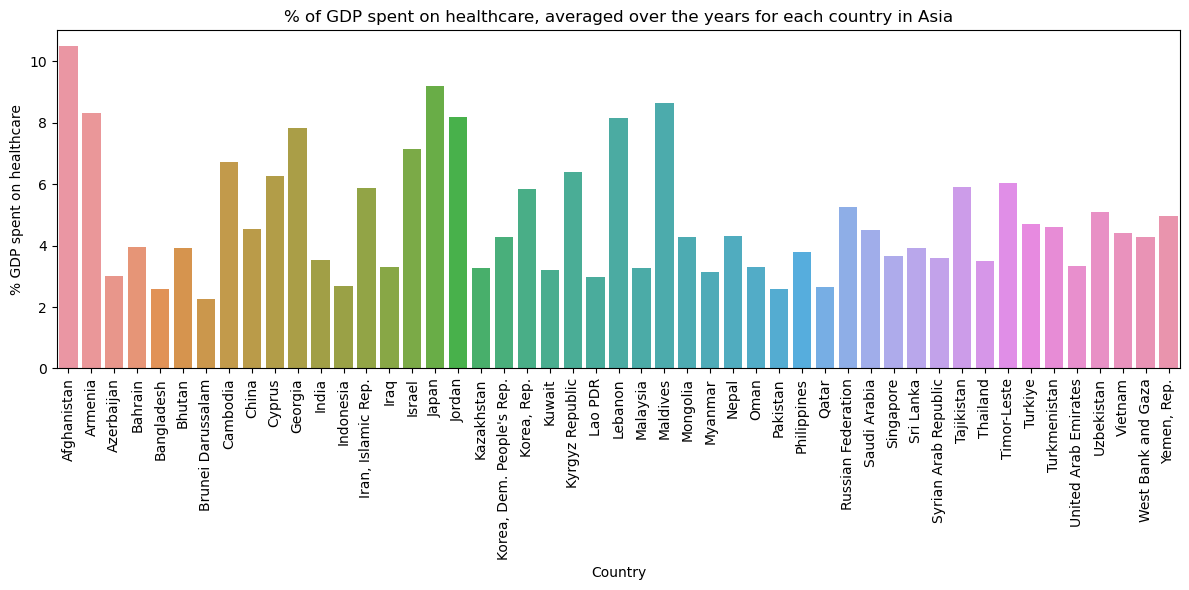

In [28]:
# Group the data by 'Country' and calculate the mean of 'gdpSpentHealthcare'
df_grouped = asia_data.groupby('Country')['gdpSpentHealthcare'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='Country', y='gdpSpentHealthcare', errorbar = None)
plt.xlabel('Country')
plt.ylabel('% GDP spent on healthcare')
plt.title('% of GDP spent on healthcare, averaged over the years for each country in Asia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Surprisingly, although Afghanistan has been spending the highest % of its GDP on healthcare, infant mortality is still high.

Let's check the environmental factors.

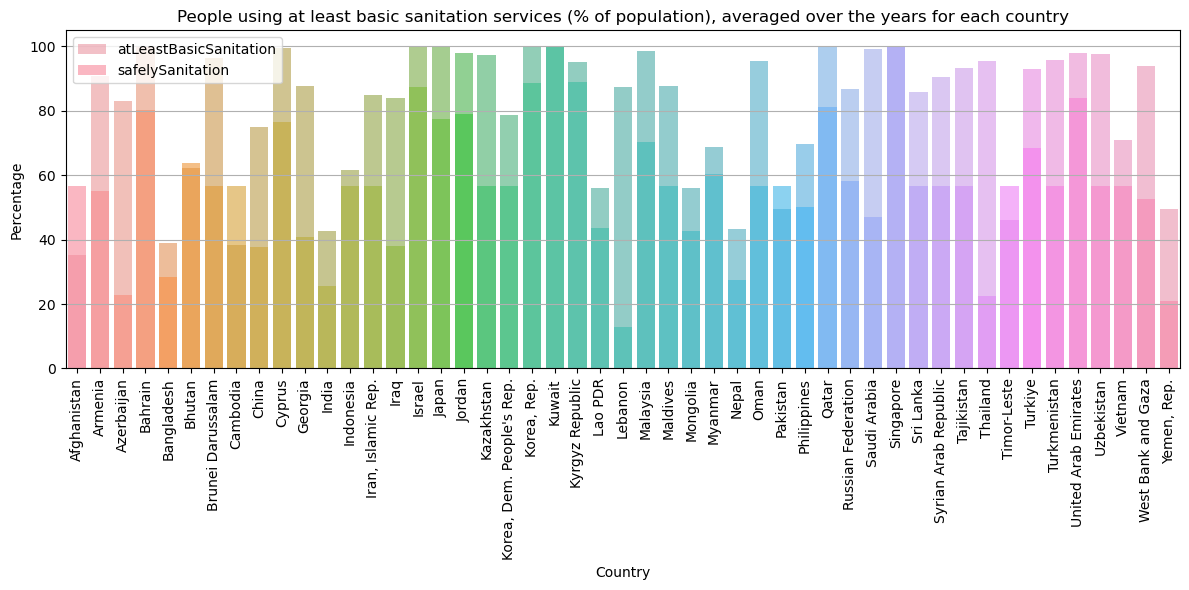

In [29]:
basic_sanit = asia_data.groupby('Country')['atLeastBasicSanitation'].mean().reset_index()
safe_sanit = asia_data.groupby('Country')['safelySanitation'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=basic_sanit, x='Country', y='atLeastBasicSanitation', alpha=0.6, label = 'atLeastBasicSanitation')
sns.barplot(data=safe_sanit, x='Country', y='safelySanitation', alpha=0.6, saturation=1, label = 'safelySanitation')
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.title('People using at least basic sanitation services (% of population), averaged over the years for each country')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.legend()
plt.show()


In [30]:
import plotly.graph_objects as go

countries = asia_data['Country'].unique()

traces = []

# Iterate over each country and create a trace for the line plot
for country in countries:
    # Filter the data for the current country
    data = asia_data[asia_data['Country'] == country]
    
    # Create a trace for the current country
    trace = go.Scatter(
        x=data['Year'],
        y=data['infantMortalityRate'],
        name=country,
        line=dict(width=2)
    )
    
    # Add the trace to the list of traces
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Infant Mortality Rate by Country from 2000 to 2020',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Infant Mortality Rate'),
    showlegend=True,
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    label=country,
                    method='update',
                    args=[{'visible': [True if trace.name == country else False for trace in traces]}],
                )
                for country in countries
            ]) +
            [
                dict(
                    label='Show All',
                    method='update',
                    args=[{'visible': [True] * len(traces)}],
                )
            ],
            direction='down',
            showactive=True,
            x=1,
            xanchor='right',
            y=1.2,
            yanchor='top',
        )
    ]
)

fig = go.Figure(data=traces, layout=layout)

fig.show()

We see that infant mortality rates are decreasing over the course of 21 years of our data, with occasional peaks that can e explained by the circumstances.

For example, a peak of infant mortality in Myanmart happened in 2008, the year that Cyclone Nargis devastated Burma (Myanmar) when it came ashore on May 3, 2008. Or in the case of Syria in 2014, the civil war took place in August-December 2014.

### Bar plot for avg infant mortality for each income group

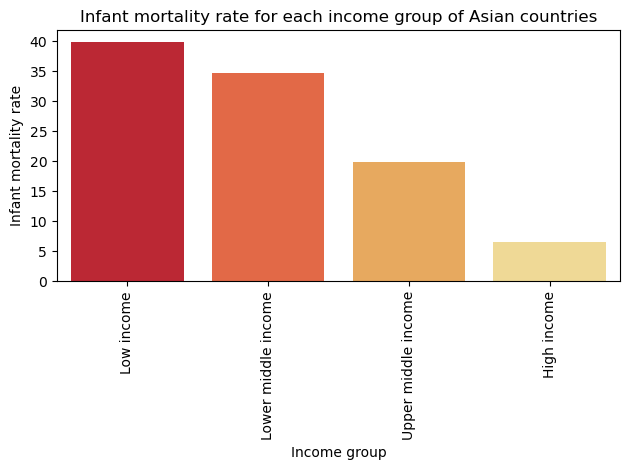

In [31]:
# Group the data by 'Income group' and calculate the mean of 'infant mortality'
df_grouped = asia_data.groupby('Income group')['infantMortalityRate'].mean() \
            .reset_index().sort_values(by = 'infantMortalityRate', ascending = False)

# Define a colormap
cmap = sns.color_palette("YlOrRd", len(asia_data['Income group'].unique()))
sns.barplot(data=df_grouped, x='Income group', y='infantMortalityRate', errorbar = None, palette=cmap[::-1])
plt.ylabel('Infant mortality rate')
plt.title('Infant mortality rate for each income group of Asian countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Bar plot for avg infant mortality for each region

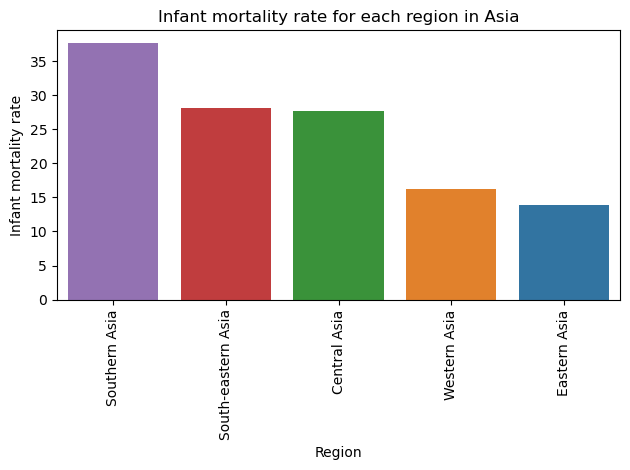

In [32]:
# Group the data by 'Region' and calculate the mean of 'infant mortality'
df_grouped = asia_data.groupby('Region')['infantMortalityRate'].mean() \
            .reset_index().sort_values(by = 'infantMortalityRate', ascending = False)

# Define a colormap
cmap = sns.color_palette("tab10", len(asia_data['Region'].unique()))
sns.barplot(data=df_grouped, x='Region', y='infantMortalityRate', errorbar = None, palette=cmap[::-1])
plt.ylabel('Infant mortality rate')
plt.title('Infant mortality rate for each region in Asia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Correlation matrix heatmap

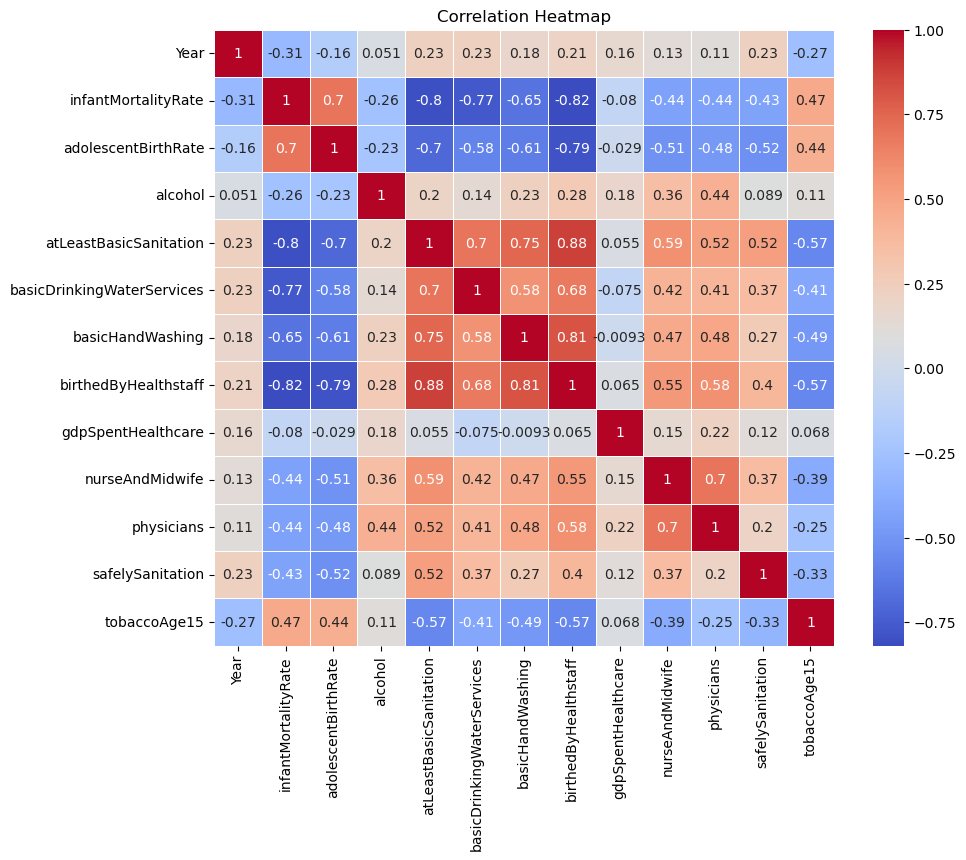

In [33]:
# Select only numeric columns for correlation calculation
numeric_columns = asia_data.select_dtypes(include='number')

# Removing Year column because the data is time series and including the "Year" 
# column in the correlation matrix may not provide meaningful insights.
# numeric_columns.drop('Year', axis = 1, inplace = True)

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Hypothesis Testing

### One-Sample T-Test

$H_0$: There is no significant difference in mean infant mortality rates in Asian countries and the global average.

$H_1$: There is a significant difference in mean infant mortality rates in Asia and other parts of the world.

In [34]:
import scipy.stats as stats

# Defining the significance level
alpha = 0.05

t_statistic, p_value = stats.ttest_1samp(asia_data.infantMortalityRate, global_avg_mortality)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Checking if the p-value is less than the significance level to reject or fail to reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis. Mean value of infant mortality rates for Asian countries is significantly different from the global average.")
else:
    print("Failed to reject the null hypothesis. There is no significant difference in infant mortality rates in Asia and other parts of the world.")


T-Statistic: -41.51462329342729
P-Value: 5.318897758944627e-222
Reject the null hypothesis. Mean value of infant mortality rates for Asian countries is significantly different from the global average.


### Two-Sample T-Test

Comparing infant mortality rates between countries with high income and countries of other income categories.

$H_0$: The mean infant mortality rate is the same between countries with high income and countries with other income categories.

$H_1$: The mean infant mortality rate is significantly higher in countries with other income categories compared to countries with high income.

In [35]:
high_income = asia_data[asia_data['Income group']=='High income'].infantMortalityRate
other_income = asia_data[asia_data['Income group']!='High income'].infantMortalityRate

# Perform the two-sample t-test
t_statistic, p_value = stats.ttest_ind(high_income, other_income)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

if p_value < alpha:
    print('Reject the null hypothesis. The mean infant mortality rate is significantly higher in countries with other income categories compared to countries with high income.')
else:
    print('Failed to reject the null hypothesis.  The mean infant mortality rate is the same between countries with high income and countries with other income categories.')
        

T-Statistic: -19.629287053647694
P-Value: 4.261024079814796e-73
Reject the null hypothesis. The mean infant mortality rate is significantly higher in countries with other income categories compared to countries with high income.


### ANOVA (Analysis of Variance)

Testing whether there are significant differences in infant mortalty rates among different regions of Asian countries.

$H_0$: There are no significant differences in the mean infant mortality rates among different regions of Asian countries.

$H_1$: There are significant differences in the mean infant mortality rates among different regions of Asian countries.

In [36]:
# Group the data by 'Region' and extract the 'infantMortalityRate' column
grouped_data = asia_data.groupby('Region')['infantMortalityRate']

alpha = 0.05

# Convert groups to NumPy arrays
group_arrays = [group.values for _, group in grouped_data]

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(*group_arrays)

# Print the results
print("F-Statistic:", f_statistic)
print("P-Value:", p_value)

if p_value < alpha:
    print('Reject the null hypothesis.')
else:
    print('Failed to reject the null hypothesis.')

F-Statistic: 63.23458406012437
P-Value: 8.41301886779941e-48
Reject the null hypothesis.


# Fitting a model

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

In [38]:
# Splitting data into features X and target variable y
X = asia_data.drop('infantMortalityRate', axis = 1)
y = asia_data.infantMortalityRate

### Proprocessing

In [39]:
columns_to_encode = ["Country", "Region", "Year"]
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown = 'ignore')
one_hot_encoded = one_hot_encoder.fit_transform(asia_data[columns_to_encode])

# Create a new dataframe with the one-hot encoded columns
one_hot_encoded_df = pd.DataFrame(
    one_hot_encoded,
    columns=one_hot_encoder.get_feature_names_out(columns_to_encode)
)

# Label encode the "Income group" column
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(asia_data["Income group"])

# Add the one-hot encoded and label encoded columns to the original dataframe
encoded_columns = one_hot_encoded_df.columns.tolist() + ["Income group"]
encoded_data = pd.concat([one_hot_encoded_df, pd.Series(label_encoded, name="Income group")], axis=1)

# Update the "asia_data" dataframe with the encoded columns
asia_data_encoded = pd.concat([asia_data.drop(columns=["Country", "Region", "Income group", "Country Code", 'Year']),
                               encoded_data], axis=1)

### Linear Regression

1. R-squared (R2): R-squared represents the proportion of the variance in the target variable that is predictable from the input variables. It ranges from 0 to 1, with higher values indicating a better fit.

2. Mean Squared Error (MSE): MSE measures the average squared difference between the predicted and actual values. It is commonly used for regression tasks, where lower values indicate better performance.

3. Root Mean Squared Error (RMSE): RMSE is the square root of MSE and provides a more interpretable measure of the average prediction error.

4. The MAE value represents the average absolute difference between the predicted and actual values. It provides a measure of how far, on average, the predictions are from the actual values. Lower MAE values indicate better model performance, as it means the model's predictions are closer to the actual values.

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Create a linear regression model
model = LinearRegression()

In [41]:
# Split the data into features (X) and target variable (y)
X = asia_data_encoded.drop("infantMortalityRate", axis=1)
y = asia_data_encoded["infantMortalityRate"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Fitting the model to train data, predicting based on train data and checking for overfitting

In [42]:
# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Calculate R-squared score
r2_train = r2_score(y_train, y_pred_train)

# Calculate mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate mean absolute error
mae_train = mean_absolute_error(y_train, y_pred_train)

# Print the evaluation metrics
print("R-squared:", r2_train)
print("Mean Squared Error:", mse_train)
print("Mean Absolute Error:", mae_train)

R-squared: 0.9783213960100652
Mean Squared Error: 8.136357642678387
Mean Absolute Error: 2.093921824929746


### Fitting the model on training data, predicting values for test data

In [43]:
# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate R-squared score
r2_linreg = r2_score(y_test, y_pred)

# Calculate mean squared error
mse_linreg = mean_squared_error(y_test, y_pred)

# Calculate mean absolute error
mae_linreg = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R-squared:", r2_linreg)
print("Mean Squared Error:", mse_linreg)
print("Mean Absolute Error:", mae_linreg)

R-squared: 0.9690690011305333
Mean Squared Error: 10.323145389268479
Mean Absolute Error: 2.370692908843419


## XGBoost

In [44]:
import xgboost as xgb

model = xgb.XGBRegressor(random_state = 42)

# Train the model
model.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("R-squared:", r2_xgb)
print("Mean Squared Error:", mse_xgb)
print("Root Mean Squared Error:", rmse_xgb)
print("Mean Absolute Error:", mae_xgb)


R-squared: 0.9861114650523148
Mean Squared Error: 4.635264645475793
Root Mean Squared Error: 2.1529664756971467
Mean Absolute Error: 1.352110361744285


### Checking the model on train data

In [45]:
model = xgb.XGBRegressor(random_state = 42)

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

r2_xgb = r2_score(y_train, y_pred)

mse_xgb = mean_squared_error(y_train, y_pred)

mae_xgb = mean_absolute_error(y_train, y_pred)

print("R-squared:", r2_xgb)
print("Mean Squared Error:", mse_xgb)
print("Mean Absolute Error:", mae_xgb)


R-squared: 0.9999798703503434
Mean Squared Error: 0.007555008104029049
Mean Absolute Error: 0.06387392583820554


### XGBoost with hyperparameter tuning

In [62]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search through
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

r2_xgb_tuned = r2_score(y_test, y_pred)
mse_xgb_tuned = mean_squared_error(y_test, y_pred)
mae_xgb_tuned = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2_xgb_tuned)
print("Mean Squared Error:", mse_xgb_tuned)
print("Mean Absolute Error:", mae_xgb_tuned)

R-squared: 0.9884233112087157
Mean Squared Error: 3.863691632561967
Mean Absolute Error: 1.19585860562556


In [63]:
best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

In [64]:
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(12)

Feature  Importance
83                Income group    0.357954
5         birthedByHealthstaff    0.329962
4             basicHandWashing    0.082619
41            Country_Pakistan    0.041620
3   basicDrinkingWaterServices    0.034353
53        Country_Turkmenistan    0.022690
7              nurseAndMidwife    0.016145
10                tobaccoAge15    0.013912
55          Country_Uzbekistan    0.013654
39               Country_Nepal    0.011806
8                   physicians    0.008024
2       atLeastBasicSanitation    0.007434

### Cross validating XGBoost model with hyperparameters

In [65]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive and calculate RMSE
cv_rmse_scores = np.sqrt(-cv_scores)

# Calculate the mean and standard deviation of RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Standard Deviation of RMSE:", std_rmse)

Cross-Validation RMSE Scores: [10.59051812  8.91517005  9.77945094 12.90633715 12.75181974]
Mean RMSE: 10.988659199761642
Standard Deviation of RMSE: 1.594131865680508
